Import Statments

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

Loading and inspecting data

In [3]:
df_train = pd.read_csv('Full-Economic-News-DFE-839861.csv', header=0, encoding = 'unicode_escape')
df_train.head()


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [4]:
from io import StringIO

col = ['relevance', 'text']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['text'])]
df_train.columns = ['relevance', 'text']

df_train['category_id'] = df_train['relevance'].factorize()[0]

category_id_df_train = df_train[['relevance', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'relevance']].values)

df_train.head()

,relevance,text,category_id
0,yes,NEW YORK -- Yields on most certificates of dep...,0
1,no,The Wall Street Journal Online</br></br>The Mo...,1
2,no,WASHINGTON -- In an effort to achieve banking ...,1
3,no,The statistics on the enormous costs of employ...,1
4,yes,NEW YORK -- Indecision marked the dollar's ton...,0


Bar chart of class proportion

In [14]:
yes_len = df_train[df_train['relevance'] == 'yes'].shape[0]
no_len = df_train[df_train['relevance'] == 'no'].shape[0]

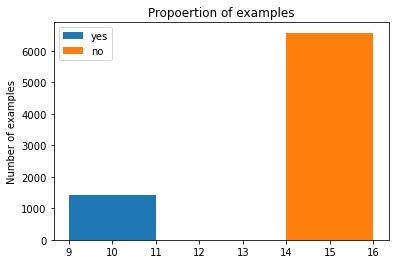

In [15]:
import matplotlib.pyplot as plt

plt.bar(10,yes_len,2, label="yes")
plt.bar(15,no_len,2, label="no")

plt.legend()
plt.ylabel('Number of examples')
plt.title('Propoertion of examples')
plt.show()

Exploration the data

In [5]:
df_train.describe()

,category_id
count,8000.000000
mean,0.823625
std,0.384103
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [6]:
df_train['message_len'] = df_train.text.apply(len)
df_train.head()

,relevance,text,category_id,message_len
0,yes,NEW YORK -- Yields on most certificates of dep...,0,1059
1,no,The Wall Street Journal Online</br></br>The Mo...,1,2553
2,no,WASHINGTON -- In an effort to achieve banking ...,1,1474
3,no,The statistics on the enormous costs of employ...,1,2673
4,yes,NEW YORK -- Indecision marked the dollar's ton...,0,1071


In [7]:
df_train[df_train.relevance == 'yes'].describe()



,category_id,message_len
count,1420.0,1420.000000
mean,0.0,1324.404930
std,0.0,406.743275
min,0.0,203.000000
25%,0.0,1074.750000
50%,0.0,1280.000000
75%,0.0,1499.250000
max,0.0,3987.000000


In [8]:
df_train[df_train.relevance == 'no'].describe()

,category_id,message_len
count,6571.0,6571.000000
mean,1.0,1416.184751
std,0.0,488.589043
min,1.0,112.000000
25%,1.0,1106.000000
50%,1.0,1338.000000
75%,1.0,1635.000000
max,1.0,5311.000000


In [9]:
df_train[df_train.message_len == 3987].text.iloc[0]

'Higher energy prices, a lousy housing market and tighter credit continue to put the squeeze on consumers -- and Wal-Mart and Home Depot are feeling their pain.</br></br>Wal-Mart Stores lowered its fiscal-year earnings forecast today, even as the world\'s biggest retailer reported that its second-quarter net income rose 49% to $3.11 billion, or 76 cents a share. The positive quarterly comparison was largely due to a charge in the year- earlier period, and CEO Lee Scott didn\'t try to hide his disappointment in his company\'s latest results. "Our underlying operating performance this quarter is not what we expect of ourselves, and not what our shareholders expect of us," he said in a statement. The retail giant said sluggishness in the overall economy contributed to its weaker outlook, but some of the problems are of Wal-Mart\'s making. Price cuts that opened the key back-to-school season lowered gross margin at U.S. stores by half a percentage point, yet piles of spring apparel remain 

Text Pre-processing

In [18]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    #Check characters again to see if they are in punctuation 
    nopunc = [char for char in mess if char not in string.punctuation]
    
    #Join the characters again to form the string
    nopunc = ''.join(nopunc)
    
    #No just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [19]:
df_train.head()

,relevance,text,category_id,message_len,clean_text
0,yes,NEW YORK -- Yields on most certificates of dep...,0,1059,NEWYORKYieldscertificatesdepositofferedmajorba...
1,no,The Wall Street Journal Online</br></br>The Mo...,1,2553,WallStreetJournalOnlinebrbrTheMorningBrieflook...
2,no,WASHINGTON -- In an effort to achieve banking ...,1,1474,WASHINGTONeffortachievebankingreformSenatenego...
3,no,The statistics on the enormous costs of employ...,1,2673,statisticsenormouscostsemployeedrugabusewellkn...
4,yes,NEW YORK -- Indecision marked the dollar's ton...,0,1071,NEWYORKIndecisionmarkeddollarstonetraderspause...


In [20]:
df_train['clean_text'] = df_train.text.apply(text_process)
df_train.head()

,relevance,text,category_id,message_len,clean_text
0,yes,NEW YORK -- Yields on most certificates of dep...,0,1059,NEW YORK Yields certificates deposit offered m...
1,no,The Wall Street Journal Online</br></br>The Mo...,1,2553,Wall Street Journal OnlinebrbrThe Morning Brie...
2,no,WASHINGTON -- In an effort to achieve banking ...,1,1474,WASHINGTON effort achieve banking reform Senat...
3,no,The statistics on the enormous costs of employ...,1,2673,statistics enormous costs employee drug abuse ...
4,yes,NEW YORK -- Indecision marked the dollar's ton...,0,1071,NEW YORK Indecision marked dollars tone trader...


In [21]:
type(stopwords.words('english'))

list

In [22]:
from collections import Counter

words = df_train[df_train.relevance == 'yes'].clean_text.apply(lambda x: [word.lower() for word in x.split()])
yes_words = Counter()

for text in words:
    yes_words.update(text)    
    
    
print(yes_words.most_common(50))


[('said', 1602), ('market', 1148), ('us', 1117), ('new', 1080), ('economy', 979), ('year', 957), ('economic', 930), ('rates', 917), ('prices', 913), ('rate', 834), ('stock', 800), ('federal', 772), ('interest', 763), ('last', 734), ('percent', 700), ('growth', 678), ('would', 634), ('rose', 624), ('index', 616), ('inflation', 614), ('average', 603), ('fed', 600), ('since', 588), ('billion', 576), ('investors', 566), ('york', 561), ('stocks', 545), ('dow', 535), ('dollar', 514), ('may', 500), ('reserve', 495), ('points', 486), ('first', 478), ('fell', 470), ('also', 443), ('quarter', 434), ('industrial', 428), ('week', 424), ('could', 421), ('years', 419), ('month', 417), ('bond', 404), ('higher', 404), ('markets', 401), ('sales', 401), ('many', 398), ('months', 393), ('jones', 392), ('report', 389), ('million', 381)]


In [23]:
from collections import Counter

words = df_train[df_train.relevance == 'no'].clean_text.apply(lambda x: [word.lower() for word in x.split()])
no_words = Counter()

for text in words:
    no_words.update(text)    
    
    
print(no_words.most_common(50))

[('said', 6637), ('new', 5013), ('market', 4350), ('us', 4217), ('would', 3857), ('year', 3781), ('stock', 3518), ('percent', 3287), ('federal', 3178), ('rates', 3031), ('economic', 2990), ('last', 2982), ('interest', 2748), ('billion', 2658), ('million', 2650), ('rate', 2424), ('economy', 2399), ('prices', 2390), ('years', 2364), ('one', 2350), ('inflation', 2086), ('president', 2031), ('also', 2018), ('york', 1997), ('first', 1987), ('investors', 1974), ('government', 1880), ('many', 1876), ('could', 1862), ('since', 1795), ('time', 1763), ('stocks', 1741), ('two', 1727), ('bank', 1717), ('may', 1707), ('week', 1699), ('growth', 1682), ('average', 1652), ('financial', 1621), ('money', 1615), ('reserve', 1609), ('yesterday', 1608), ('mr', 1551), ('tax', 1540), ('markets', 1528), ('fed', 1522), ('companies', 1480), ('price', 1458), ('much', 1452), ('even', 1431)]


Vectorization

In [25]:
X = df_train.clean_text
y = df_train.category_id

print(X.shape)
print(y.shape)

(8000,)
(8000,)


Split into training and test sets

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6000,)
(2000,)
(6000,)
(2000,)


CountVectorizer

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

learn training data vocabulary

In [29]:
X_train_dtm = vect.transform(X_train)

combine fit and transform into a single step

In [30]:
X_train_dtm = vect.fit_transform(X_train)

the document-term matrix

In [31]:
X_train_dtm

<6000x69016 sparse matrix of type '<class 'numpy.int64'>'
	with 655753 stored elements in Compressed Sparse Row format>

transform testing data

In [33]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<2000x69016 sparse matrix of type '<class 'numpy.int64'>'
	with 205476 stored elements in Compressed Sparse Row format>

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<6000x69016 sparse matrix of type '<class 'numpy.float64'>'
	with 655753 stored elements in Compressed Sparse Row format>

Building and evaluating a model

import and instantiate a Multinomial Naive Bayes


In [39]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

train the model

In [40]:
%time nb.fit(X_train_dtm, y_train)

CPU times: user 20.8 ms, sys: 16 µs, total: 20.8 ms
Wall time: 20.4 ms


MultinomialNB()

Class prediction

In [42]:
y_pred_class = nb.predict(X_test_dtm)

accuracy of class predictions

In [43]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.809

print the confusion matrix

In [44]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[  89,  254,    0],
       [ 124, 1529,    0],
       [   1,    3,    0]])

In [45]:
X_test.shape

(2000,)

print text for yes

In [48]:
X_test[y_pred_class > y_test]

5606    Stocks advanced broadly today breaking fourday...
4824    Stock prices tumbled fourth straight day yeste...
2745    Americans earning money socking away spending ...
1307    quirky mix assets markets worldwide benefited ...
1610    NEW YORK days immediately Iraqs Aug invasion K...
                              ...                        
210     History mark 2014 year predicted 49 years ago ...
7927    NEW YORK May 20ÛÓLateafternoon action failed ...
3298    WASHINGTON US greatly strengthened hand Treasu...
366     Easy Money Tugs Two Ways Trade GapbrbrThe trad...
496     Federal Reserves Sept 18 decision stay course ...
Name: clean_text, Length: 254, dtype: object

print text for yes

In [49]:
X_test[y_pred_class < y_test]

444     Bet FedbrbrTo Give ShelterbrbrIn Market Stormb...
4941    unsettling report consumer incomes set spate p...
2004    NEW YORK Bond prices rebounded yesterday key s...
5605    Stocks rallied sharply first time nearly two w...
2973    Investors reeling last weeks record stock mark...
                              ...                        
3167    WASHINGTON problems economy inflation apparent...
4926    drop oil prices upbeat outlooks WalMart Lowes ...
7605    Wall Street finished uninspired session mixed ...
2706    DIGESTING Federal Reserves interestrate increa...
4722    Personal income newhome sales rose third strai...
Name: clean_text, Length: 128, dtype: object

In [50]:
X_test[444]

'Bet FedbrbrTo Give ShelterbrbrIn Market StormbrbrVolatility Wall Street tame long recent splashes seemed like tidal waves rippling throughout stock markets Unnerved investors turned hopes Federal Reserve rate cut shelterbrbrNo question stocks recent ups downs dizzying hitting record closing high 1278664 Feb 20 March 5 recent closing low Dow Jones Industrial Average lost 736 points nearly 6'

calculate predicted probabilities

In [52]:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([1.        , 0.99906218, 0.99700192, ..., 1.        , 1.        ,
       0.0100221 ])

import an instantiate a logistic regression model

In [53]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')

In [55]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 4.27 s, sys: 241 ms, total: 4.51 s
Wall time: 3.57 s


LogisticRegression(solver='liblinear')

class predictions

In [56]:
y_pred_class = logreg.predict(X_test_dtm)

calculate predicted probabilities

In [57]:
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.99820376, 0.98731138, 0.97561765, ..., 0.99519455, 0.99980543,
       0.57464014])

calculate accuracy

In [59]:
metrics.accuracy_score(y_test, y_pred_class)

0.788

In [60]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[  78,  265,    0],
       [ 155, 1498,    0],
       [   1,    3,    0]])